## Setup (env, Spark, load features)

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from pyspark.sql import SparkSession

In [2]:
# 1) Env & paths
load_dotenv(find_dotenv(usecwd=True), override=True)
DATA_DIR = os.getenv("DATA_DIR")
assert DATA_DIR and os.path.isdir(DATA_DIR), f"DATA_DIR invalid: {DATA_DIR}"

# 2) Spark (used only to load parquet and convert to pandas)
spark = SparkSession.builder.appName("HealthClaims_TrainXGB").getOrCreate()

# 3) Load features saved by 02_label_features
feat_dir = os.path.abspath(os.path.join(DATA_DIR, "..", "processed", "features_parquet"))
features = spark.read.parquet(feat_dir).cache()
features.createOrReplaceTempView("features_v0")

print("Features rows:", features.count())
features.printSchema()
features.limit(5).show(truncate=False)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/28 17:00:39 WARN Utils: Your hostname, JINUTSA, resolves to a loopback address: 127.0.1.1; using 10.4.8.103 instead (on interface enp37s0f0)
25/10/28 17:00:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/28 17:00:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/28 17:00:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/28 17:00:40 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/10/28 17:00:40 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


Features rows: 1163
root
 |-- patient_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- race: string (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- age_at_index: decimal(13,0) (nullable = true)
 |-- index_date: date (nullable = true)
 |-- last_enc_date: date (nullable = true)
 |-- n_encounters: long (nullable = true)
 |-- n_conditions: long (nullable = true)
 |-- n_procedures: long (nullable = true)
 |-- n_medications: long (nullable = true)
 |-- n_observations: long (nullable = true)
 |-- n_claims: long (nullable = true)
 |-- hist_total_cost: double (nullable = true)
 |-- n_unique_providers: long (nullable = true)
 |-- n_unique_departments: long (nullable = true)
 |-- n_claims_with_diag: long (nullable = true)
 |-- claim_span_days: integer (nullable = true)
 |-- cost_next_window: double (nullable = true)
 |-- label: integer (nullable = true)

+------------------------------------+------+-----+-----------+------------+----------+-------------+----

## Time-based split (index_date) & pandas conversion

In [3]:
import pandas as pd
from pyspark.sql import functions as F

# Time split (mimics production): train on earlier index dates, test on later ones
CUT = "2020-10-15"
train_df = spark.sql(f"SELECT * FROM features_v0 WHERE index_date < DATE('{CUT}')")
test_df  = spark.sql(f"SELECT * FROM features_v0 WHERE index_date >= DATE('{CUT}')")

print("Train rows:", train_df.count(), " Test rows:", test_df.count())

# Columns we’ll use (v0 features)
CAT = ["gender","race","ethnicity"]
NUM = [
    "age_at_index", "n_encounters", "n_conditions", "n_procedures", "n_medications",
    "n_observations", "n_claims", "hist_total_cost",
    "n_unique_providers", "n_unique_departments", "claim_span_days"
]
TARGET = "label"

train_pd = train_df.select(*(CAT + NUM + [TARGET])).toPandas()
test_pd  = test_df.select(*(CAT + NUM + [TARGET])).toPandas()

# Sanity on class balance (train/test)
print("Train label counts:\n", train_pd[TARGET].value_counts(dropna=False))
print("Test  label counts:\n", test_pd[TARGET].value_counts(dropna=False))


Train rows: 914  Test rows: 249
Train label counts:
 label
0    662
1    252
Name: count, dtype: int64
Test  label counts:
 label
0    152
1     97
Name: count, dtype: int64


## One-hot encoding, alignment, and class weight

In [4]:
# Categoricals → category dtype
for c in CAT:
    train_pd[c] = train_pd[c].astype("category")
    test_pd[c]  = test_pd[c].astype("category")

# One-hot (drop_first avoids perfect multicollinearity)
X_train = pd.get_dummies(train_pd[CAT + NUM], drop_first=True)
X_test  = pd.get_dummies(test_pd[CAT + NUM], drop_first=True)

# Align columns (add missing columns to test, in same order as train)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train_pd[TARGET].astype(int).values
y_test  = test_pd[TARGET].astype(int).values

# Optional: drop any constant columns (rare but possible)
const_cols = [c for c in X_train.columns if X_train[c].nunique() <= 1]
if const_cols:
    X_train = X_train.drop(columns=const_cols)
    X_test  = X_test.drop(columns=const_cols)
    print("Dropped constant columns:", const_cols)

# Compute scale_pos_weight to handle imbalance: (#neg / #pos) on train
import numpy as np
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print(f"scale_pos_weight (neg/pos): {scale_pos_weight:.2f} (neg={neg}, pos={pos})")

# Keep metadata for inference
feature_columns = X_train.columns.tolist()
cat_snapshot = {c: list(train_pd[c].cat.categories) for c in CAT}


scale_pos_weight (neg/pos): 2.63 (neg=662, pos=252)


In [5]:
from itertools import product
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    ConfusionMatrixDisplay, precision_score, accuracy_score, recall_score, f1_score
)
from sklearn.calibration import CalibratedClassifierCV
import mlflow
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mlflow.tracking import MlflowClient
import numpy as np
import os

# ---------------------- MLflow setup ----------------------
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
mlruns_clean_path = os.path.join(project_root, "mlruns_clean")

os.makedirs(mlruns_clean_path, exist_ok=True)
mlflow.set_tracking_uri(f"file://{mlruns_clean_path}")
print("Tracking URI set to:", mlflow.get_tracking_uri())

experiment_name = "health_claims_highcost_xgb"
client = MlflowClient()
if not client.get_experiment_by_name(experiment_name):
    client.create_experiment(name=experiment_name)
mlflow.set_experiment(experiment_name)

# ---------------------- CV setup ----------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------- Parameter grid ----------------------
param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05],
    "n_estimators": [300, 500],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "gamma": [0.2],
    "min_child_weight": [5],
    "reg_lambda": [2.0],
}

# ---------------------- Log-transform skewed columns ----------------------
skewed_cols = [c for c in ["hist_total_cost", "n_claims"] if c in X_train.columns]
for col in skewed_cols:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

print("Log-transformed columns:", skewed_cols)

# # ---------------------- Feature engineering ----------------------
# def add_engineered_features(df):
#     df = df.copy()
#     df["avg_cost_per_claim"] = df["hist_total_cost"] / (df["n_claims"] + 1)
#     df["claims_per_provider"] = df["n_claims"] / (df["n_unique_providers"] + 1)
#     df["encounters_per_condition"] = df["n_encounters"] / (df["n_conditions"] + 1)
#     df["claim_days_density"] = df["n_claims"] / (df["claim_span_days"] / 30 + 1)
#     return df

# X_train_fe = add_engineered_features(X_train)
# X_test_fe  = add_engineered_features(X_test)

# # Log-transform skewed features
# skewed_cols = [c for c in ["hist_total_cost", "n_claims", "avg_cost_per_claim"] if c in X_train_fe.columns]
# for col in skewed_cols:
#     X_train_fe[col] = np.log1p(X_train_fe[col])
#     X_test_fe[col]  = np.log1p(X_test_fe[col])

# print("Feature-engineered columns added:", set(X_train_fe.columns) - set(X_train.columns))
# print("Log-transformed columns:", skewed_cols)


# ---------------------- Run grid search ----------------------
for i, (md, lr, ne, ss, csbt, gamma, min_child_weight, reg_lambda) in enumerate(product(
    param_grid["max_depth"],
    param_grid["learning_rate"],
    param_grid["n_estimators"],
    param_grid["subsample"],
    param_grid["colsample_bytree"],
    param_grid["gamma"],
    param_grid["min_child_weight"],
    param_grid["reg_lambda"]
)):
    with mlflow.start_run(run_name=f"xgb_run_cv_{i}"):
        mlflow.set_tag("mlflow.runName", f"xgb_run_cv_{i}")
        mlflow.log_params({
            "max_depth": md,
            "learning_rate": lr,
            "n_estimators": ne,
            "subsample": ss,
            "colsample_bytree": csbt,
            "gamma": gamma,
            "min_child_weight": min_child_weight,
            "reg_lambda": reg_lambda,
            "scale_pos_weight": scale_pos_weight,
        })

        # Define model
        xgb = XGBClassifier(
            max_depth=md,
            learning_rate=lr,
            n_estimators=ne,
            subsample=ss,
            colsample_bytree=csbt,
            gamma=gamma,
            min_child_weight=min_child_weight,
            reg_lambda=reg_lambda,
            objective="binary:logistic",
            eval_metric="auc",
            tree_method="hist",
            random_state=42,
            scale_pos_weight=scale_pos_weight
        )

        # Calibrated model
        xgb = CalibratedClassifierCV(xgb, method="sigmoid", cv=3)

        # Cross-validation scoring
        scores = cross_validate(
            xgb, X_train, y_train,
            scoring=["roc_auc", "average_precision"],
            cv=cv, return_train_score=False
        )

        mlflow.log_metric("cv_roc_auc", scores["test_roc_auc"].mean())
        mlflow.log_metric("cv_pr_auc", scores["test_average_precision"].mean())

        # Fit full training set and evaluate on test
        xgb.fit(X_train, y_train)
        #mlflow.xgboost.log_model(xgb, name="model")
        mlflow.sklearn.log_model(xgb, artifact_path="model")
        proba_test = xgb.predict_proba(X_test)[:, 1]
        pred_test = (proba_test >= 0.2).astype(int)

        # Compute and log metrics
        precision = precision_score(y_test, pred_test)
        recall = recall_score(y_test, pred_test)
        f1 = f1_score(y_test, pred_test)
        accuracy = accuracy_score(y_test, pred_test)
        roc_auc = roc_auc_score(y_test, proba_test)
        pr_auc = average_precision_score(y_test, proba_test)

        mlflow.log_metrics({
            "test_precision": precision,
            "test_recall": recall,
            "test_f1": f1,
            "test_accuracy" : accuracy,
            "test_roc_auc": roc_auc,
            "test_pr_auc": pr_auc
        })


print("\n All XGBoost runs completed successfully.")


Tracking URI set to: file:///home/utsajinlab/health_claims_ml/notebooks/mlruns_clean
Log-transformed columns: ['hist_total_cost', 'n_claims']


2025/10/28 17:00:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/28 17:01:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/28 17:01:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/28 17:01:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/28 17:01:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/28 17:01:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/28 17:01:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use 


 All XGBoost runs completed successfully.


## Visualize MLflow Run Results

In [6]:
from mlflow.tracking import MlflowClient
import pandas as pd

client = MlflowClient(tracking_uri=f"file://{mlruns_clean_path}")
experiment = client.get_experiment_by_name("health_claims_highcost_xgb")

# Load top based on cv_roc_auc
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.test_f1 DESC"],   
    max_results=30
)

results = []
for r in runs:
    results.append({
        "run_id": r.info.run_id,
        "run_name": r.data.tags.get("mlflow.runName", ""),
        "cv_roc_auc": r.data.metrics.get("cv_roc_auc"),
        "cv_pr_auc": r.data.metrics.get("cv_pr_auc"),
        "test_roc_auc": r.data.metrics.get("test_roc_auc"),
        "test_pr_auc": r.data.metrics.get("test_pr_auc"),
        "test_accuracy": r.data.metrics.get("test_accuracy"),
        "test_precision": r.data.metrics.get("test_precision"),
        "test_recall": r.data.metrics.get("test_recall"),
        "test_f1": r.data.metrics.get("test_f1"),
    })

df_results = pd.DataFrame(results)
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", 30)       # Show all 30 rows
display(df_results)

best_run = runs[0]
print("\n===== Best XGB Run Parameters =====")
for k, v in best_run.data.params.items():
    print(f"{k}: {v}")

print("\n===== Best XGB Run Metrics =====")
for k, v in best_run.data.metrics.items():
    print(f"{k}: {v:.4f}")

best_run_id = best_run.info.run_id
print("\nBest run_id:", best_run_id)


,run_id,run_name,cv_roc_auc,cv_pr_auc,test_roc_auc,test_pr_auc,test_accuracy,test_precision,test_recall,test_f1
0,e774ec18ada84188b14d9b9c99cef594,xgb_run_cv_4,0.780146,0.605914,0.777333,0.619311,0.706827,0.576923,0.927835,0.711462
1,0dc5f728f317408ab685d32f33590736,xgb_run_cv_8,0.780685,0.603191,0.779164,0.620099,0.702811,0.573248,0.927835,0.708661
2,5a0382b121b340f48eb0b63ab1c62bb3,xgb_run_cv_5,0.779323,0.605176,0.778283,0.620582,0.702811,0.574194,0.917526,0.706349
3,4bdd798ac91d4fd89895d133ddc18ebf,xgb_run_cv_1,0.779310,0.600006,0.780114,0.623963,0.698795,0.570513,0.917526,0.703557
4,1b65b4f0b5d747c9ba83f306413673b9,xgb_run_cv_9,0.780610,0.607174,0.778893,0.619694,0.698795,0.571429,0.907216,0.701195
5,d4ce480a544b4c88b2bc650907d8b77b,xgb_run_cv_9,0.781039,0.611349,0.773535,0.619090,0.698795,0.575342,0.865979,0.691358
6,e5074019946d418cacb62607bb7491a6,xgb_run_cv_4,0.781384,0.603259,0.771229,0.615480,0.694779,0.570470,0.876289,0.691057
7,52c0fe58066f49cd892dedd401d8dabd,xgb_run_cv_2,0.777093,0.602929,0.779571,0.618238,0.686747,0.561290,0.896907,0.690476
8,57306594c3cb46eeabc9f403f1d0cc23,xgb_run_cv_1,0.780844,0.601410,0.770822,0.611032,0.694779,0.571429,0.865979,0.688525
9,81c3bea5f1954857a448b0b2422600ca,xgb_run_cv_7,0.766699,0.604546,0.769466,0.606385,0.706827,0.588235,0.824742,0.686695



===== Best XGB Run Parameters =====
reg_lambda: 2.0
learning_rate: 0.01
min_child_weight: 5
max_depth: 4
colsample_bytree: 0.8
gamma: 0.2
subsample: 0.8
n_estimators: 300
scale_pos_weight: 2.626984126984127

===== Best XGB Run Metrics =====
test_precision: 0.5769
test_roc_auc: 0.7773
test_accuracy: 0.7068
cv_roc_auc: 0.7801
test_recall: 0.9278
cv_pr_auc: 0.6059
test_f1: 0.7115
test_pr_auc: 0.6193

Best run_id: e774ec18ada84188b14d9b9c99cef594



===== Best XGB Run Parameters =====
reg_lambda: 2.0
learning_rate: 0.01
min_child_weight: 5
max_depth: 5
colsample_bytree: 0.8
gamma: 0.2
subsample: 0.8
n_estimators: 500
scale_pos_weight: 2.626984126984127

===== Best XGB Run Metrics =====
test_precision: 0.5753
test_roc_auc: 0.7735
test_accuracy: 0.6988
cv_roc_auc: 0.7810
test_recall: 0.8660
cv_pr_auc: 0.6113
test_f1: 0.6914
test_pr_auc: 0.6191

Best run_id: d4ce480a544b4c88b2bc650907d8b77b


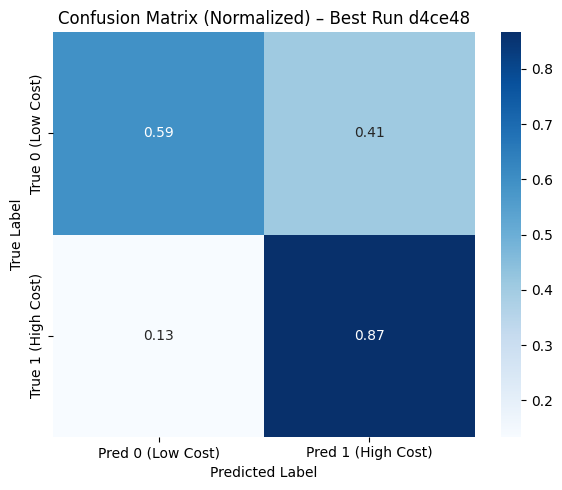


Raw Confusion Matrix (counts):
        Pred 0  Pred 1
True 0      90      62
True 1      13      84


In [16]:
from mlflow.tracking import MlflowClient
import pandas as pd

# Connect to your MLflow experiment
client = MlflowClient(tracking_uri=f"file://{mlruns_clean_path}")
experiment = client.get_experiment_by_name("health_claims_highcost_xgb")

# Get all runs and sort by test_f1
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.test_f1 DESC"],
    max_results=1
)

best_run = runs[0]
print("\n===== Best XGB Run Parameters =====")
for k, v in best_run.data.params.items():
    print(f"{k}: {v}")

print("\n===== Best XGB Run Metrics =====")
for k, v in best_run.data.metrics.items():
    print(f"{k}: {v:.4f}")

best_run_id = best_run.info.run_id
print("\nBest run_id:", best_run_id)


# ploting the confusion matrix
# --- Load the model ---
model_uri = f"runs:/{best_run_id}/model"
model = mlflow.sklearn.load_model(model_uri)

# --- Predict on your test set ---
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.2).astype(int)   # use your decision threshold

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# --- Plot using Seaborn ---
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm, annot=True, fmt=".2f", cmap="Blues",
    xticklabels=["Pred 0 (Low Cost)", "Pred 1 (High Cost)"],
    yticklabels=["True 0 (Low Cost)", "True 1 (High Cost)"]
)
plt.title(f"Confusion Matrix (Normalized) – Best Run {best_run_id[:6]}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# --- Print raw counts for clarity ---
print("\nRaw Confusion Matrix (counts):")
print(pd.DataFrame(
    cm,
    columns=["Pred 0", "Pred 1"],
    index=["True 0", "True 1"]
))
